In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
!wget https://file.io/sK7fpQJKDJ8v

--2022-05-08 14:39:32--  https://file.io/sK7fpQJKDJ8v
Resolving file.io (file.io)... 34.197.64.69, 107.20.27.254
Connecting to file.io (file.io)|34.197.64.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.file.io/deleted [following]
--2022-05-08 14:39:32--  https://www.file.io/deleted
Resolving www.file.io (www.file.io)... 13.225.26.20, 13.225.26.59, 13.225.26.57, ...
Connecting to www.file.io (www.file.io)|13.225.26.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361411 (353K) [text/html]
Saving to: ‘sK7fpQJKDJ8v’

sK7fpQJKDJ8v        100%[===================>] 352.94K  --.-KB/s    in 0.02s   

2022-05-08 14:39:33 (20.4 MB/s) - ‘sK7fpQJKDJ8v’ saved [361411/361411]



In [ ]:
!unzip drive/MyDrive/newhandPDDataset.zip -d /content/data/

Archive:  drive/MyDrive/newhandPDDataset.zip
   creating: /content/data/newhandPDDataset/
   creating: /content/data/newhandPDDataset/test/
   creating: /content/data/newhandPDDataset/test/healthy/
  inflating: /content/data/newhandPDDataset/test/healthy/circA-P14.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/circA-P17.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/circA-P19.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/circA-P21.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/circA-P23.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/circA-p27.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/circA-P3.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/circA-P8.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/mea1-H1.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/mea1-H10.jpg  
  inflating: /content/data/newhandPDDataset/test/healthy/mea1-H11.jpg  
  inf

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/newhandPDDataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


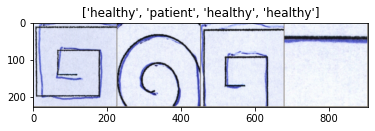

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} - {data[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8512 Acc: 0.6583
val Loss: 0.3969 Acc: 0.8205

Epoch 1/24
----------
train Loss: 0.6667 Acc: 0.6897
val Loss: 0.8050 Acc: 0.7607

Epoch 2/24
----------
train Loss: 0.8088 Acc: 0.7128
val Loss: 0.4298 Acc: 0.7949

Epoch 3/24
----------
train Loss: 0.5879 Acc: 0.7505
val Loss: 0.3989 Acc: 0.8291

Epoch 4/24
----------
train Loss: 0.6036 Acc: 0.7694
val Loss: 0.4198 Acc: 0.7863

Epoch 5/24
----------
train Loss: 0.4750 Acc: 0.7925
val Loss: 0.3314 Acc: 0.8632

Epoch 6/24
----------
train Loss: 0.5388 Acc: 0.7736
val Loss: 0.2515 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4519 Acc: 0.7715
val Loss: 0.2704 Acc: 0.8547

Epoch 8/24
----------
train Loss: 0.3829 Acc: 0.8302
val Loss: 0.2379 Acc: 0.9060

Epoch 9/24
----------
train Loss: 0.3935 Acc: 0.8239
val Loss: 0.2601 Acc: 0.8547

Epoch 10/24
----------
train Loss: 0.3577 Acc: 0.8637
val Loss: 0.2540 Acc: 0.8547

Epoch 11/24
----------
train Loss: 0.4103 Acc: 0.8176
val Loss: 0.3016 Acc: 0.8547

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


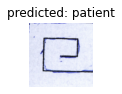

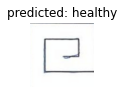

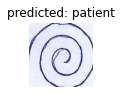

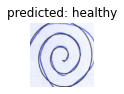

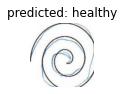

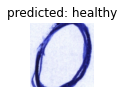

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6175 Acc: 0.6751
val Loss: 0.4893 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.6536 Acc: 0.7128
val Loss: 0.3682 Acc: 0.8034

Epoch 2/24
----------
train Loss: 0.6597 Acc: 0.7044
val Loss: 0.3460 Acc: 0.8205

Epoch 3/24
----------
train Loss: 0.6651 Acc: 0.6876
val Loss: 0.3345 Acc: 0.8462

Epoch 4/24
----------
train Loss: 0.5471 Acc: 0.7442
val Loss: 0.3126 Acc: 0.8632

Epoch 5/24
----------
train Loss: 0.6429 Acc: 0.7149
val Loss: 0.3524 Acc: 0.8120

Epoch 6/24
----------
train Loss: 0.7148 Acc: 0.6792
val Loss: 0.3456 Acc: 0.8205

Epoch 7/24
----------
train Loss: 0.4627 Acc: 0.7778
val Loss: 0.3499 Acc: 0.8291

Epoch 8/24
----------
train Loss: 0.4233 Acc: 0.8008
val Loss: 0.3114 Acc: 0.8120

Epoch 9/24
----------
train Loss: 0.4214 Acc: 0.8218
val Loss: 0.3256 Acc: 0.8547

Epoch 10/24
----------
train Loss: 0.4474 Acc: 0.7987
val Loss: 0.3310 Acc: 0.7949

Epoch 11/24
----------
train Loss: 0.4828 Acc: 0.7610
val Loss: 0.3154 Acc: 0.8376

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


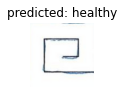

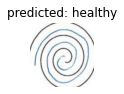

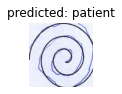

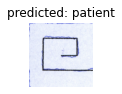

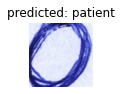

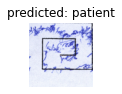

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

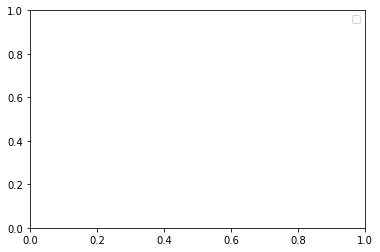

<Figure size 432x288 with 0 Axes>

In [ ]:
visualize_model(model_conv)
plt.ion()
plt.ioff()
plt.show()
plt.figure()